In [0]:
#setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, round, sum, avg, when
from pyspark.sql.window import Window
from pyspark.sql.functions import broadcast
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
#iniciar spark
spark = SparkSession.builder \
    .appName("Case ifood teste AB") \
    .getOrCreate()

In [0]:
#caminho para buscar os dados
base_path = "/Volumes/workspace/default/case_ifood/process/"

In [0]:
#popular datasets
df_pedido = spark.read.format("delta").load(base_path+"pedido") .select("customer_id", "order_id", "order_total_amount")
df_teste  = spark.read.format("delta").load(base_path+"teste")
df_pedido.limit(1).show()
df_teste.limit(1).show()

+--------------------+--------------------+------------------+
|         customer_id|            order_id|order_total_amount|
+--------------------+--------------------+------------------+
|7ba88a68bb2a3504c...|33e0612d62e5eb42a...|              46.0|
+--------------------+--------------------+------------------+

+--------------------+---------+
|         customer_id|is_target|
+--------------------+---------+
|755e1fa18f25caec5...|   target|
+--------------------+---------+



In [0]:
#join para ter o dados do teste AB
df_analise_target = df_pedido.join(broadcast(df_teste), on="customer_id",how="inner")
df_analise_target.limit(1).show()

+--------------------+--------------------+------------------+---------+
|         customer_id|            order_id|order_total_amount|is_target|
+--------------------+--------------------+------------------+---------+
|7ba88a68bb2a3504c...|33e0612d62e5eb42a...|              46.0|  control|
+--------------------+--------------------+------------------+---------+



In [0]:
#Agregações por usuário: número de pedidos e ticket médio
df_analise_por_user = (
    df_analise_target.groupBy("customer_id", "is_target")
    .agg(
        count("order_id").alias("num_pedidos"),
        avg("order_total_amount").alias("ticket_medio_raw")
    )
    .withColumn("ticket_medio", round(col("ticket_medio_raw"), 2))
    .drop("ticket_medio_raw")
)
df_analise_por_user.limit(5).show()

+--------------------+---------+-----------+------------+
|         customer_id|is_target|num_pedidos|ticket_medio|
+--------------------+---------+-----------+------------+
|d5e5786712aab146d...|   target|          2|       54.85|
|75079416ac8a6ffa2...|   target|          8|        30.8|
|c3d63c8da7deacfe7...|  control|          1|        13.0|
|0cdb302403bc5f856...|   target|         28|       26.79|
|b9f1a6d57026536b9...|  control|         33|       41.13|
+--------------------+---------+-----------+------------+



In [0]:
#acrescentar variavel retido
df_analise_por_user = df_analise_por_user.withColumn("retido", when(col("num_pedidos") >= 2, 1).otherwise(0))
display(df_analise_por_user.limit(5))

customer_id,is_target,num_pedidos,ticket_medio,retido
d5e5786712aab146d52de71fc1218669607512be770e568b9eb611bcd311f09e,target,2,54.85,1
75079416ac8a6ffa2107c1ed4451cb11cb89e0be9c2323cb84343ee34dcb389b,target,8,30.8,1
c3d63c8da7deacfe7d213f8d0599ce192ceb7c83f0f6288a8d2b5b893b4f8b42,control,1,13.0,0
0cdb302403bc5f8567baa1ed22bb4fee8823b30363dca5ddd16494836cc9bee1,target,28,26.79,1
b9f1a6d57026536b99ddd59f71748acc51f6f2b728c89cb3c127f9ba77d49afd,control,33,41.13,1


In [0]:
#Agregações por usuário: número de pedidos e ticket médio com target
df_agg_analise= (
    df_analise_por_user.groupBy("is_target", "retido")
    .agg(
        count("*").alias("qtd_usuarios"),
        sum("num_pedidos").alias("total_pedidos"),
        avg("num_pedidos").alias("raw_qtd_media_pedidos"),
        avg("ticket_medio").alias("raw_media_ticket")
    )
    .withColumn("ticket_medio", round(col("raw_media_ticket"), 2))
    .drop("raw_media_ticket")
    .withColumn("qtd_media_pedidos", round(col("raw_qtd_media_pedidos"), 2))
    .drop("raw_qtd_media_pedidos")
    .orderBy("is_target", "retido")
)
df_agg_analise.show()

+---------+------+------------+-------------+------------+-----------------+
|is_target|retido|qtd_usuarios|total_pedidos|ticket_medio|qtd_media_pedidos|
+---------+------+------------+-------------+------------+-----------------+
|  control|     0|       91201|        91201|       48.08|              1.0|
|  control|     1|      269341|      1434375|       47.99|             5.33|
|   target|     0|       91386|        91386|       48.05|              1.0|
|   target|     1|      354538|      2045359|       47.78|             5.77|
+---------+------+------------+-------------+------------+-----------------+



In [0]:
# Calcular taxa de retenção
window_spec = Window.partitionBy("is_target")

df_analise_taxa = df_agg_analise.withColumn(
    "total_por_grupo", sum("qtd_usuarios").over(window_spec)
).withColumn(
    "taxa_retencao", round(col("qtd_usuarios") / col("total_por_grupo") * 100, 2)
)

display(df_analise_taxa)

is_target,retido,qtd_usuarios,total_pedidos,ticket_medio,qtd_media_pedidos,total_por_grupo,taxa_retencao
control,0,91201,91201,48.08,1.0,360542,25.3
control,1,269341,1434375,47.99,5.33,360542,74.7
target,0,91386,91386,48.05,1.0,445924,20.49
target,1,354538,2045359,47.78,5.77,445924,79.51


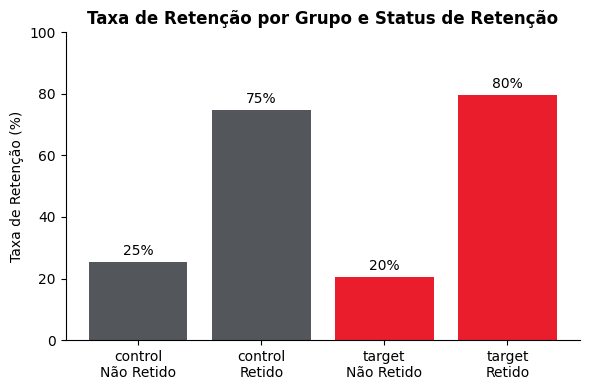

In [0]:
#grafico taxa de retenção

# Coletar dados para pandas
df_plot = df_analise_taxa.toPandas() 

# Cores de identidade visual do iFood 
colors_ifood = {
    'control': '#53565A', #cinza escuro
    'target': '#EA1D2C'   # vermelho iFood
}

# Gráfico
fig, ax = plt.subplots(figsize=(6, 4))

# Plotando as barras
for idx, row in df_plot.iterrows():
    bar = ax.bar(
        f"{row['is_target']}\n{'Retido' if row['retido'] == 1 else 'Não Retido'}",
        row['taxa_retencao'],
        color=colors_ifood[row['is_target']]
    )
    ax.bar_label(bar, labels=[f"{row['taxa_retencao']:.0f}%"], fontsize=10, label_type='edge', padding=3)

# Estilo
ax.set_title('Taxa de Retenção por Grupo e Status de Retenção', fontsize=12, weight='bold')
ax.set_ylabel('Taxa de Retenção (%)')
ax.set_ylim(0, 100)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

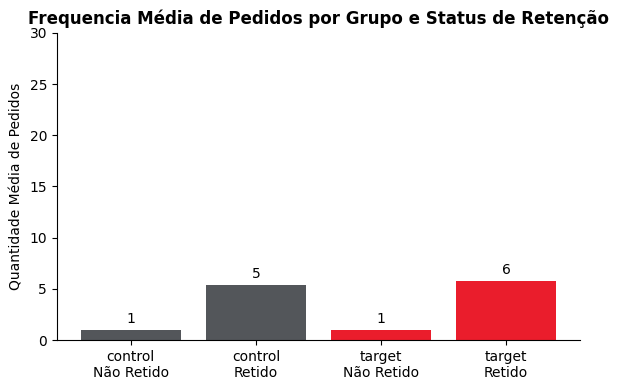

In [0]:
#grafico frequencia de pedidos

# Coletar dados para pandas
df_plot = df_analise_taxa.toPandas() 

# Cores de identidade visual do iFood 
colors_ifood = {
    'control': '#53565A', #cinza escuro
    'target': '#EA1D2C'   # vermelho iFood
}

# Gráfico
fig, ax = plt.subplots(figsize=(6, 4))

# Plotando as barras
for idx, row in df_plot.iterrows():
    bar = ax.bar(
        f"{row['is_target']}\n{'Retido' if row['retido'] == 1 else 'Não Retido'}",
        row['qtd_media_pedidos'],
        color=colors_ifood[row['is_target']]
    )
    ax.bar_label(bar, labels=[f"{row['qtd_media_pedidos']:.0f}"], fontsize=10, label_type='edge', padding=3)

# Estilo
ax.set_title('Frequencia Média de Pedidos por Grupo e Status de Retenção', fontsize=12, weight='bold')
ax.set_ylabel('Quantidade Média de Pedidos')
ax.set_ylim(0, 30)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

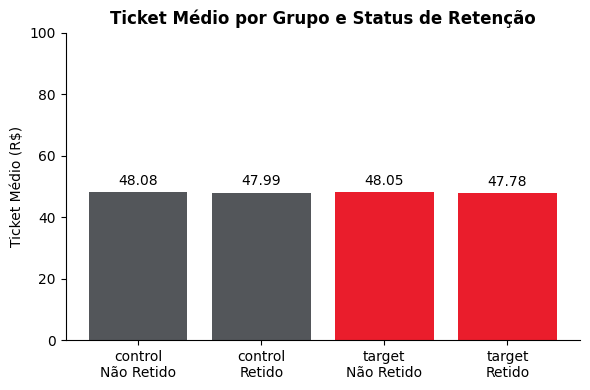

In [0]:
#grafico Ticket Médio

# Coletar dados para pandas
df_plot = df_analise_taxa.toPandas() 

# Cores de identidade visual do iFood 
colors_ifood = {
    'control': '#53565A', #cinza escuro
    'target': '#EA1D2C'   # vermelho iFood
}

# Gráfico
fig, ax = plt.subplots(figsize=(6, 4))

# Plotando as barras
for idx, row in df_plot.iterrows():
    bar = ax.bar(
        f"{row['is_target']}\n{'Retido' if row['retido'] == 1 else 'Não Retido'}",
        row['ticket_medio'],
        color=colors_ifood[row['is_target']]
    )
    ax.bar_label(bar, labels=[f"{row['ticket_medio']:.2f}"], fontsize=10, label_type='edge', padding=3)

# Estilo
ax.set_title('Ticket Médio por Grupo e Status de Retenção', fontsize=12, weight='bold')
ax.set_ylabel('Ticket Médio (R$)')
ax.set_ylim(0, 100)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [0]:
# Filtrar percentual de retenção para control
percentual_control = df_analise_taxa.filter(
    (col("is_target") == "control") & (col("retido") == 1)
).select("taxa_retencao").collect()[0][0]

# Filtrar percentual de retenção para target
percentual_target = df_analise_taxa.filter(
    (col("is_target") == "target") & (col("retido") == 1)
).select("taxa_retencao").collect()[0][0]

#Valores de retenção
print(f"Percentual de clientes retidos no grupo de controle: {percentual_control}%")
print(f"Percentual de clientes retidos no grupo alvo: {percentual_target}%")
print(f"Diferença percentual: {percentual_target - percentual_control:.2f}%")


Percentual de clientes retidos no grupo de controle: 74.7%
Percentual de clientes retidos no grupo alvo: 79.51%
Diferença percentual: 4.81%


In [0]:
# Coletar dados para pandas
data = df_analise_taxa.toPandas()

# Separar dados
success = [
    data[(data['is_target'] == 'control') & (data['retido'] == 1)]['qtd_usuarios'].values[0],
    data[(data['is_target'] == 'target') & (data['retido'] == 1)]['qtd_usuarios'].values[0]
]

nobs = [
    data[data['is_target'] == 'control']['qtd_usuarios'].sum(),
    data[data['is_target'] == 'target']['qtd_usuarios'].sum()
]

# Teste z de proporção
from statsmodels.stats.proportion import proportions_ztest

stat, pval = proportions_ztest(count=success, nobs=nobs)
print(f"Estatística Z: {stat:.3f}, p-valor: {pval:.2e}")

Estatística Z: -51.231, p-valor: 0.00e+00
